In [66]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler

from statsmodels.formula.api import ols



from scipy import stats
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings 

warnings.filterwarnings("ignore")

%matplotlib inline

## Decisions! 

- Dummy columns for zip codes are well worth it. improve the accuracy of the model by 10k
- dummy columns for month categories. then categorize them into peak and off peak.
- All of the zipcodes in the holdout data are in the training set!!! we are good to go

## To do!
- Create the function that will take a dataframe and get it to the point that it 
    - has geohash dummies
    - has zip code dummies 
    - has month dummies 
- Outlier analysis on the bedrooms and bathrooms columns to find out what a 0 means.


In [67]:
# import libraries 
X = pd.read_csv('../raw/X.csv')
y = pd.read_csv('../raw/y.csv', header=None, names=['price'])
geo= pd.read_csv('../cleanedData/geohashed_full.csv')
print(len(X), len(y), len(geo))

17290 17290 17290


In [68]:
y

,price
0,365000.0
1,865000.0
2,1038000.0
3,1490000.0
4,711000.0
...,...
17285,750000.0
17286,440000.0
17287,310000.0
17288,427500.0


In [69]:
X_full = pd.concat([X, geo], axis=1)

In [70]:
# Split the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X_full, y,               # Pass in our X and y
                                                    random_state=42,    # Abritary select a random_state 
                                                    test_size=.2        # Split test size to be 20% of full data.
                                                   )

In [71]:
lr = LinearRegression()
model = lr.fit(X_train.drop(columns=['id', 'date']), y_train)
y_hat = model.predict(X_test.drop(columns=['id','date']))
RMSE = mean_squared_error(y_test, y_hat)
RMSE**0.5



162557.98030660837

## We can go bigger

Let's split the zipcodes up into dummy columns too.

In [72]:
zipcode_dummies_train = pd.get_dummies(X_train.zipcode)
zipcode_dummies_test = pd.get_dummies(X_test.zipcode)

In [73]:
zipcode_dummies_train.shape, zipcode_dummies_test.shape, y_train.shape

((13832, 70), (3458, 70), (13832, 1))

In [74]:
# concatenate the zipcodes apart from 1 onto the data frames and run the tests.
X_train = pd.concat([X_train, zipcode_dummies_train.iloc[:,:-1]], axis = 1)
X_test = pd.concat([X_test, zipcode_dummies_test.iloc[:,:-1]], axis = 1)

In [75]:
lr = LinearRegression()
model = lr.fit(X_train.drop(columns=['date']), y_train)
y_hat = model.predict(X_test.drop(columns=['date']))
RMSE = mean_squared_error(y_test, y_hat)
RMSE**0.5

153116.75104455333

In [76]:
X_train.shape

(13832, 286)

## zipcodes help the model perform slightly better over all!


In [56]:
def drop_last(n):
    return int(str(n)[:-1])

X_train.zipcode = X_train.zipcode.apply(lambda x: drop_last(x))
X_test.zipcode = X_test.zipcode.apply(lambda x: drop_last(x))

In [57]:
zipcode_dummies_train = pd.get_dummies(X_train.zipcode)
zipcode_dummies_test = pd.get_dummies(X_test.zipcode)
(zipcode_dummies_test.shape), (zipcode_dummies_train.shape)

((3458, 19), (13832, 19))

In [60]:
lr = LinearRegression()
model = lr.fit(zipcode_dummies_train, y_train)
y_hat = model.predict(zipcode_dummies_test)
RMSE = mean_squared_error(y_test, y_hat)
RMSE**0.5

354245.44794474315

In [122]:
# lets make a column for months, see if there is a linear relatioonahsip or if it is more categorical

zipcode_dummies_test.head()

,98001,98002,98003,98004,98005,98006,98007,98008,98010,98011,...,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
2950,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16390,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1599,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9575,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
# create month columns
month_train = pd.to_datetime(X_train.date)
month_test = pd.to_datetime(X_test.date)

month_train = month_train.dt.strftime('%m').astype(int)
month_test = month_test.dt.strftime('%m').astype(int)
X_train['month'] = month_train
                                     
X_test['month'] = month_test

In [87]:
# see if there is a linear relationship
model = ols(formula='price~month', data=pd.concat([X_train.month, y_train], axis=1)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.274
Date:                Sun, 18 Oct 2020   Prob (F-statistic):              0.259
Time:                        17:53:58   Log-Likelihood:            -1.9717e+05
No. Observations:               13832   AIC:                         3.943e+05
Df Residuals:                   13830   BIC:                         3.944e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.503e+05   7482.291     73.544      0.000    5.36e+05    5.65e+05
month      -1158.6168   1026.386     -1.129      0.259   -3170.472     853.239
==============================================================================
Omnibus:                    13042.445   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1000612.324
Skew:                           4.365   Prob(JB):                         0.00
Kurtosis:                      43.742   Cond. No.                         17.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Month does not have a linear relationship with price


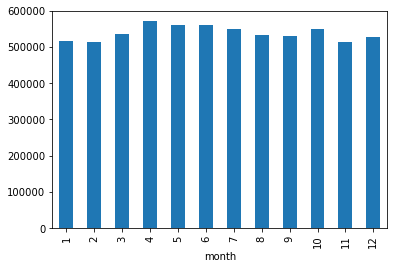

In [89]:
pd.concat([X_train, y_train], axis=1).groupby(['month']).price.mean().plot(kind='bar')

## Housing prices seem pretty consistant accross the months

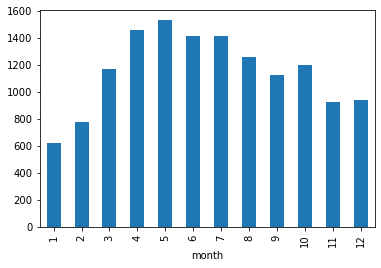

In [91]:
pd.concat([X_train, y_train], axis=1).groupby(['month']).price.count().plot(kind='bar');

### Many more houses are sold in 4th and 5th

In [95]:
# Let's test the pricing between months

test = pd.concat([X_train, y_train], axis=1)
df_peak = test[(test.month == 4) |
               (test.month == 5) |
              (test.month == 6) |
              (test.month == 7)]

df_ofpeak = test[(test.month == 1) |
               (test.month == 2) |
              (test.month == 3) |
              (test.month == 8) |
                (test.month == 9) |
                (test.month == 10) |
                (test.month == 11) |
                (test.month == 12)]


In [96]:
stats.ttest_ind(df_peak.price, df_ofpeak.price, equal_var=False)

Ttest_indResult(statistic=4.793654830718005, pvalue=1.6571062002661236e-06)

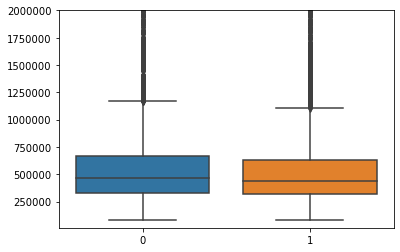

In [101]:
ax = sns.boxplot(data = [df_peak.price, df_ofpeak.price])
ax.set_ylim(10000,2000000);

### Peak (blue) has a signeficantly higher median price than offpeak.

However, there seems to be a sin/polynomial relationship between housing month and 

In [108]:

test.sort_values('bathrooms', ascending=False)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,98148,98155,98166,98168,98177,98178,98188,98198,month,price
10366,6762700020,20141013T000000,6,8.00,12050,27600,2.5,0,3,4,...,0,0,0,0,0,0,0,0,10,7700000.0
3275,1225069038,20140505T000000,7,8.00,13540,307752,3.0,0,4,3,...,0,0,0,0,0,0,0,0,5,2280000.0
7519,9208900037,20140919T000000,6,7.75,9890,31374,2.0,0,4,3,...,0,0,0,0,0,0,0,0,9,6885000.0
2505,9175600025,20141007T000000,7,6.75,7480,41664,2.0,0,2,3,...,0,0,1,0,0,0,0,0,10,800000.0
15816,1924059029,20140617T000000,5,6.75,9640,13068,1.0,1,4,3,...,0,0,0,0,0,0,0,0,6,4668000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10067,3980300371,20140926T000000,0,0.00,290,20875,1.0,0,0,1,...,0,0,0,0,0,0,0,0,9,142000.0
9286,2954400190,20140624T000000,0,0.00,4810,28008,2.0,0,0,3,...,0,0,0,0,0,0,0,0,6,1295650.0
1120,6306400140,20140612T000000,0,0.00,3064,4764,3.5,0,2,3,...,0,0,0,0,0,0,0,0,6,1095000.0
12982,203100435,20140918T000000,1,0.00,690,23244,1.0,0,0,4,...,0,0,0,0,0,0,0,0,9,484000.0


In [109]:
test[test.bathrooms == 0]

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,98148,98155,98166,98168,98177,98178,98188,98198,month,price
10067,3980300371,20140926T000000,0,0.0,290,20875,1.0,0,0,1,...,0,0,0,0,0,0,0,0,9,142000.0
9286,2954400190,20140624T000000,0,0.0,4810,28008,2.0,0,0,3,...,0,0,0,0,0,0,0,0,6,1295650.0
5424,3918400017,20150205T000000,0,0.0,1470,979,3.0,0,2,3,...,0,0,0,0,0,0,0,0,2,380000.0
12982,203100435,20140918T000000,1,0.0,690,23244,1.0,0,0,4,...,0,0,0,0,0,0,0,0,9,484000.0
1120,6306400140,20140612T000000,0,0.0,3064,4764,3.5,0,2,3,...,0,0,0,0,0,0,0,0,6,1095000.0


In [111]:
test[test.bedrooms == 0].lat

10067    47.5308
9286     47.6642
10074    47.3493
5424     47.7145
6409     47.7222
2430     47.4177
1120     47.6362
Name: lat, dtype: float64

In [113]:
test[test.bedrooms == 0].price

10067     142000.0
9286     1295650.0
10074     240000.0
5424      380000.0
6409      288000.0
2430      265000.0
1120     1095000.0
Name: price, dtype: float64

In [131]:
test_ready = test.drop(columns=['id', 'date'] )

In [132]:
month_dummies = pd.get_dummies(test_ready.month)
test_ready = pd.concat([test_ready, month_dummies], axis=1)

In [133]:
lr = LinearRegression()
lr.fit(test_ready, y_train)
lr.predict()

TypeError: predict() missing 1 required positional argument: 'X'

In [123]:
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,98148,98155,98166,98168,98177,98178,98188,98198,month,price
2498,1776460190,20140626T000000,3,2.50,2370,5353,2.0,0,0,3,...,0,0,0,0,0,0,0,0,6,429900.0
10932,2144800215,20140519T000000,4,1.75,2080,13629,1.0,0,0,4,...,0,0,0,0,0,1,0,0,5,285000.0
15638,7891600165,20140627T000000,1,1.00,700,2500,1.0,0,0,4,...,0,0,0,0,0,0,0,0,6,295000.0
15099,8732190200,20150115T000000,4,2.25,2490,7233,1.0,0,0,3,...,0,0,0,0,0,0,0,0,1,275000.0
15560,9122001230,20141205T000000,3,3.50,1970,5079,2.0,0,0,3,...,0,0,0,0,0,0,0,0,12,590000.0


In [134]:
df = pd.read_csv('../raw/kc_holdout_data.csv')

In [141]:
holdout = set(df.zipcode.unique())

In [140]:
train = set(X_train.zipcode.unique())

In [142]:
holdout.difference(train)

set()